In [21]:
import pandas as pd
import numpy as np
import pyagrum as gum
import pyagrum.lib.notebook as gnb

# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('Dataset/processed_credit.csv')
vars_df.head()

CheckingAccount Duration                               CreditHistory  \
0             lt0    Short  Critical account / other credits elsewhere   
1          0to200   Medium         Existing credits paid duly till now   
2     No Checking    Short  Critical account / other credits elsewhere   
3             lt0   Medium         Existing credits paid duly till now   
4             lt0    Short             Delay in paying off in the past   

               Purpose CreditAmount        SavingsAccount EmploymentSince  \
0     radio/television          Low  unknown / no savings       ge7 years   
1     radio/television          Low              lt100 DM      1to4 years   
2            education          Low              lt100 DM      4to7 years   
3  furniture/equipment       Medium              lt100 DM      4to7 years   
4            car (new)          Low              lt100 DM      1to4 years   

   InstallmentRate                   PersonalStatusSex OtherDebtors  \
0                4                        male: single         none   
1                2  female: divorced/separated/married         none   
2                2                        male: single         none   
3                2                        male: single    guarantor   
4                3                        male: single         none   

   ResidenceSince                                   Property     Age  \
0               4                                real estate     Old   
1               2                                real estate   Young   
2               3                                real estate  Middle   
3               4  building society savings / life insurance  Middle   
4               4                      unknown / no property  Middle   

  OtherInstallmentPlans   Housing  ExistingCredits                        Job  \
0                  none       own                2  skilled employee/official   
1                  none       own                1  skilled employee/official   
2                  none       own                1       unskilled - resident   
3                  none  for free                1  skilled employee/official   
4                  none  for free                2  skilled employee/official   

   LiablePeople         Telephone ForeignWorker CreditRisk  
0             1  yes (registered)           yes       Good  
1             1              none           yes        Bad  
2             2              none           yes       Good  
3             2              none           yes       Good  
4             2              none           yes        Bad

# Open a saved Bayesian network

In [22]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum

filepath = 'BNs/GermanCreditManual.bif'
bn = gum.loadBN(filepath)
bn

(pyagrum.BayesNet@000002064AE64490) BN{nodes: 26, arcs: 36, domainSize: 10^13.7638, dim: 3736, mem: 55Ko 912o}

Populate random variable values with dataframe column value ranges

In [23]:
# Find observed and unobserved variables
bn_vars = set(bn.names())
df_vars = set(vars_df.columns)
observed_vars = df_vars.intersection(bn_vars)
unobserved_vars = bn_vars - observed_vars
print(f"Observed: {observed_vars}, Unobserved: {unobserved_vars}")
print(len(bn_vars))

Observed: {'OtherInstallmentPlans', 'ForeignWorker', 'Duration', 'SavingsAccount', 'ExistingCredits', 'Property', 'Purpose', 'CreditHistory', 'Job', 'PersonalStatusSex', 'CreditRisk', 'InstallmentRate', 'CreditAmount', 'ResidenceSince', 'EmploymentSince', 'OtherDebtors', 'CheckingAccount', 'Housing', 'LiablePeople', 'Age'}, Unobserved: {'Capacity', 'Capital', 'Character', 'Income', 'Collateral', 'Terms'}
26


In [24]:
def inspect_var_ranges(bn, df=None, sample_rows=5):
	"""Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
	mismatches = []
	for var in bn.names():
		try:
			variable = bn.variable(var)
			try:
				labels = list(variable.labels())
			except Exception:
                # fall back to older API
				labels = [str(variable.label(i)) for i in range(variable.domainSize())]
			uniques = df[var].dropna().unique()
			
			if set(labels) != set(uniques):
				# print(f" - {var}: sample_uniques={list(sorted(map(str, uniques)))}")
				# print(f" - {var}: labels={labels}\n")
				print(f"Mismatch in variable '{var}':")
				print(set(labels), '\n', set(uniques))
				mismatches.append(var)
		except Exception as e:
			pass

	if mismatches:
		return set(mismatches)
	else:
		print("All variable labels match the dataset.")
		return None
    
mismatches = inspect_var_ranges(bn, df=vars_df)
mismatches

Mismatch in variable 'SavingsAccount':
{'_100to500_DM', 'ge1000_DM', 'lt100_DM', 'unknown__no_savings', '_500to1000_DM'} 
 {'lt100 DM', '500to1000 DM', 'unknown / no savings', '100to500 DM', 'ge1000 DM'}
Mismatch in variable 'ExistingCredits':
{'1', '2', '4', '3'} 
 {np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Mismatch in variable 'Property':
{'building_society_savings__life_insurance', 'unknown__no_property', 'real_estate', 'car_or_other'} 
 {'building society savings / life insurance', 'real estate', 'unknown / no property', 'car or other'}
Mismatch in variable 'Purpose':
{'business', 'retraining', 'car_new', 'car_used', 'radio_television', 'repairs', 'others', 'education', 'furniture_equipment', 'domestic_appliances'} 
 {'business', 'retraining', 'car (new)', 'radio/television', 'repairs', 'others', 'car (used)', 'education', 'domestic appliances', 'furniture/equipment'}
Mismatch in variable 'CreditHistory':
{'Critical_account__other_credits_elsewhere', 'All_credits_at_this_

{'CheckingAccount',
 'CreditHistory',
 'EmploymentSince',
 'ExistingCredits',
 'Housing',
 'InstallmentRate',
 'Job',
 'LiablePeople',
 'OtherDebtors',
 'PersonalStatusSex',
 'Property',
 'Purpose',
 'ResidenceSince',
 'SavingsAccount'}

In [25]:
# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(bn.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

# Verify that all mismatches have been resolved
mismatches_after = inspect_var_ranges(bn, df=vars_df)
mismatches_after
vars_df.head()

All variable labels match the dataset.


CheckingAccount Duration                              CreditHistory  \
0             lt0    Short  Critical_account__other_credits_elsewhere   
1     No_Checking   Medium        Existing_credits_paid_duly_till_now   
2         _0to200    Short  Critical_account__other_credits_elsewhere   
3             lt0   Medium        Existing_credits_paid_duly_till_now   
4             lt0    Short            Delay_in_paying_off_in_the_past   

               Purpose CreditAmount       SavingsAccount EmploymentSince  \
0     radio_television          Low  unknown__no_savings       ge7_years   
1     radio_television          Low             lt100_DM     _1to4_years   
2            education          Low             lt100_DM     _4to7_years   
3  furniture_equipment       Medium             lt100_DM     _4to7_years   
4              car_new          Low             lt100_DM     _1to4_years   

  InstallmentRate                  PersonalStatusSex OtherDebtors  \
0               4                        male_single         none   
1               2  female_divorced_separated_married         none   
2               2                        male_single         none   
3               2                        male_single    guarantor   
4               3                        male_single         none   

  ResidenceSince                                  Property     Age  \
0              4                               real_estate     Old   
1              2                               real_estate   Young   
2              3                               real_estate  Middle   
3              4  building_society_savings__life_insurance  Middle   
4              4                      unknown__no_property  Middle   

  OtherInstallmentPlans   Housing ExistingCredits                        Job  \
0                  none       own               2  skilled_employee_official   
1                  none       own               1  skilled_employee_official   
2                  none       own               1        unskilled__resident   
3                  none  for_free               1  skilled_employee_official   
4                  none  for_free               2  skilled_employee_official   

  LiablePeople         Telephone ForeignWorker CreditRisk  
0            1  yes (registered)           yes       Good  
1            1              none           yes        Bad  
2            2              none           yes       Good  
3            2              none           yes       Good  
4            2              none           yes        Bad

# Building probability tables

In [26]:
# Augment vars_df with unobserved variables (random values from BN labels)
unobs_seed = 42
np.random.seed(unobs_seed)

# Custom probabilities for unobserved variables
custom_probs = {
    "Collateral": [0.7, 0.2, 0.1],  
    "Capital": [0.7, 0.2, 0.1],
	"Capacity": [0.3, 0.4, 0.3],
	"Terms": [0.45, 0.35, 0.2],
	"Character": [0.22, 0.78],
	"Income": [0.1, 0.3, 0.6]
}

for var in unobserved_vars:
    labels = list(bn.variable(var).labels())
    probs = custom_probs.get(var, None)
    if probs is not None and len(probs) == len(labels):
        # Note use of np.random.choice with specified probabilities
        vars_df[var] = np.random.choice(labels, size=len(vars_df), p=probs)
    else:
        print(f"Warning: Using uniform distribution for '{var}' due to missing or mismatched custom probabilities.")
        # Fall back to uniform if no custom probs provided or length mismatch
        vars_df[var] = np.random.choice(labels, size=len(vars_df))
    print(f"Added column '{var}' with random values from {labels}")

# Only use vars from bn - telephone not in bn
vars_df = vars_df[list(bn.names())]

print(f"\nAugmented DataFrame shape: {vars_df.shape}")
vars_df.head()

Added column 'Capacity' with random values from ['low', 'medium', 'high']
Added column 'Capital' with random values from ['low', 'medium', 'high']
Added column 'Character' with random values from ['bad', 'good']
Added column 'Income' with random values from ['low', 'medium', 'high']
Added column 'Collateral' with random values from ['none', 'some', 'good']
Added column 'Terms' with random values from ['short', 'medium', 'long']

Augmented DataFrame shape: (1000, 26)


OtherInstallmentPlans ForeignWorker Collateral Duration  \
0                  none           yes       none    Short   
1                  none           yes       some   Medium   
2                  none           yes       some    Short   
3                  none           yes       none   Medium   
4                  none           yes       none    Short   

        SavingsAccount ExistingCredits  \
0  unknown__no_savings               2   
1             lt100_DM               1   
2             lt100_DM               1   
3             lt100_DM               1   
4             lt100_DM               2   

                                   Property Capacity Capital  \
0                               real_estate   medium     low   
1                               real_estate     high     low   
2                               real_estate     high  medium   
3  building_society_savings__life_insurance   medium  medium   
4                      unknown__no_property      low  medium   

               Purpose  Income                              CreditHistory  \
0     radio_television    high  Critical_account__other_credits_elsewhere   
1     radio_television    high        Existing_credits_paid_duly_till_now   
2            education  medium  Critical_account__other_credits_elsewhere   
3  furniture_equipment    high        Existing_credits_paid_duly_till_now   
4              car_new    high            Delay_in_paying_off_in_the_past   

    Terms                        Job                  PersonalStatusSex  \
0   short  skilled_employee_official                        male_single   
1  medium  skilled_employee_official  female_divorced_separated_married   
2    long        unskilled__resident                        male_single   
3   short  skilled_employee_official                        male_single   
4    long  skilled_employee_official                        male_single   

  CreditRisk InstallmentRate CreditAmount ResidenceSince EmploymentSince  \
0       Good               4          Low              4       ge7_years   
1        Bad               2          Low              2     _1to4_years   
2       Good               2          Low              3     _4to7_years   
3       Good               2       Medium              4     _4to7_years   
4        Bad               3          Low              4     _1to4_years   

  OtherDebtors CheckingAccount Character   Housing LiablePeople     Age  
0         none             lt0      good       own            1     Old  
1         none     No_Checking      good       own            1   Young  
2         none         _0to200      good       own            2  Middle  
3    guarantor             lt0      good  for_free            2  Middle  
4         none             lt0      good  for_free            2  Middle

In [27]:
queries = {"OtherDebtors", "EmploymentSince", "PersonalStatusSex", "LiablePeople", "CheckingAccount", "SavingsAccount"}

def populate_cpts(bn, df, alpha=1.0):
    df = df.copy()

    for var in bn.names():
        # ensure label types are strings and in BN order
        labels = [str(l) for l in bn.variable(var).labels()]
        parents = [bn.variable(pid).name() for pid in bn.parents(bn.idFromName(var))]

        if not parents:
            counts = df[var].astype(str).value_counts().reindex(labels, fill_value=0)
            smoothed = counts + alpha
            probs = (smoothed / smoothed.sum()).astype(float).values
            bn.cpt(var).fillWith(probs)
        else:
            # Ordered list of parent label lists (keeps order consistent with `parents`)
            parent_labels_list = [[str(l) for l in bn.variable(p).labels()] for p in parents]

            # Build index appropriate to number of parents
            if len(parents) == 1:
                index = pd.Index(parent_labels_list[0], name=parents[0])
            else:
                index = pd.MultiIndex.from_product(parent_labels_list, names=parents)

            # Group using stringified values so they match BN labels exactly
            grp = df[parents + [var]].astype(str)
            counts = grp.groupby(parents)[var].value_counts().unstack(fill_value=0)

            # reindex -> guarantees all parent combinations and child labels present (zeros where missing)
            counts = counts.reindex(index=index, columns=labels, fill_value=0)

            # Laplace smoothing and row-normalise
            smoothed = counts + alpha
            cond = smoothed.div(smoothed.sum(axis=1), axis=0).fillna(0)

            # set CPT entries
            for idx, row in cond.iterrows():
                if len(parents) == 1:
                    parent_assignment = {parents[0]: idx}
                else:
                    parent_assignment = dict(zip(parents, idx if isinstance(idx, tuple) else (idx,)))
                pr = row.astype(float).values.tolist()
                bn.cpt(var)[parent_assignment] = pr

    return bn

bn = populate_cpts(bn, vars_df, alpha=1.0)

# Inference using the Bayesian Network

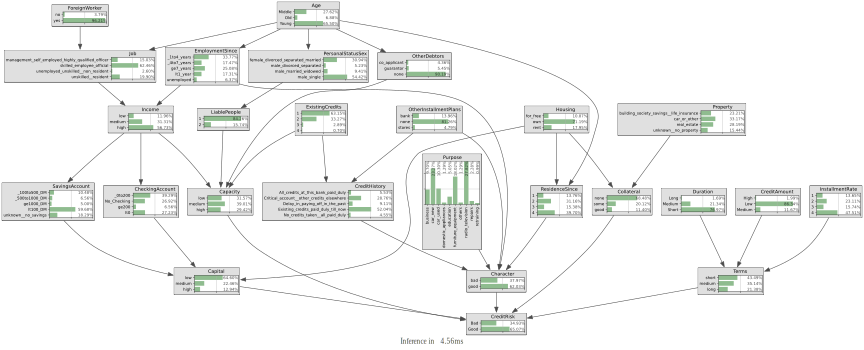

In [28]:
gum.config.reset()
# Inference
gnb.showInference(bn, size="12")

Given 5 C's lets test it's impact on the perceived Credit Risk

{'Character', 'Income', 'CreditRisk', 'Collateral', 'Terms', 'Capacity', 'Capital'}


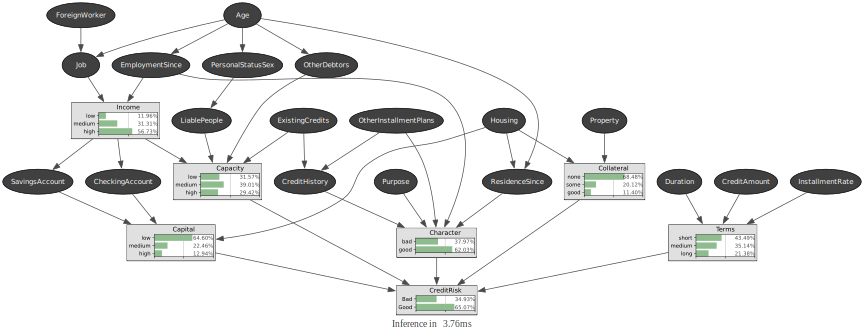

In [29]:
targets = unobserved_vars.union({"CreditRisk"})
print(targets)
gnb.showInference(bn,evs={},targets=targets, size="12")


# Causal reasoning

We explore the effect that parent nodes have on the perceived credit risk of applicants, investigating the link between employment, asset ownership and the financial wellbeing of applicants. 

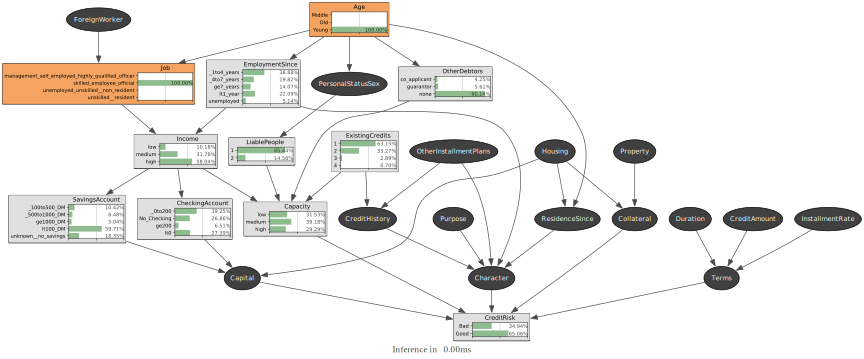

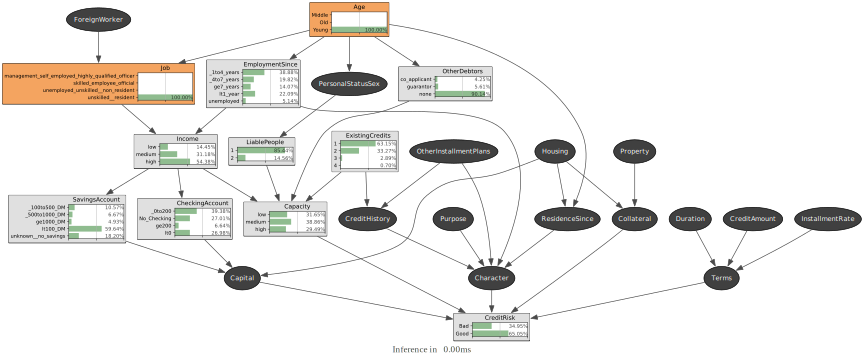

In [30]:
employment = {"CreditRisk", "Job", "Age", "EmploymentSince", "Income", "Capacity",
              "LiablePeople", "ExistingCredits", "OtherDebtors", "CheckingAccount", "SavingsAccount"}

gnb.showInference(bn,evs={"Age": "Young", "Job": "skilled_employee_official"},targets=employment, size="12")
gnb.showInference(bn,evs={"Age": "Young", "Job": "unskilled__resident"},targets=employment, size="12")


# Exploration of Character -> CreditRisk

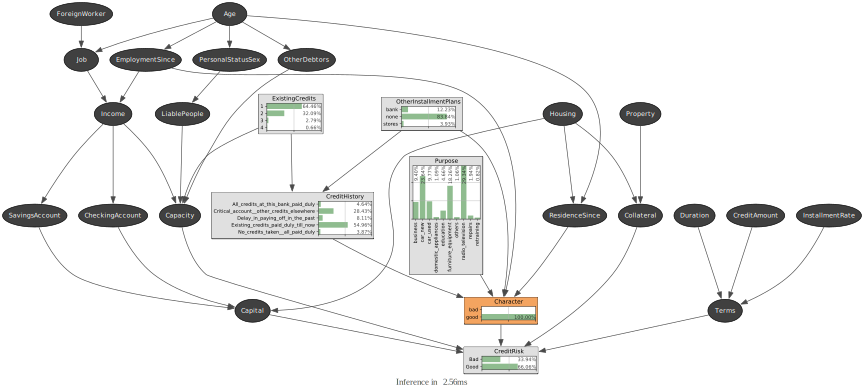

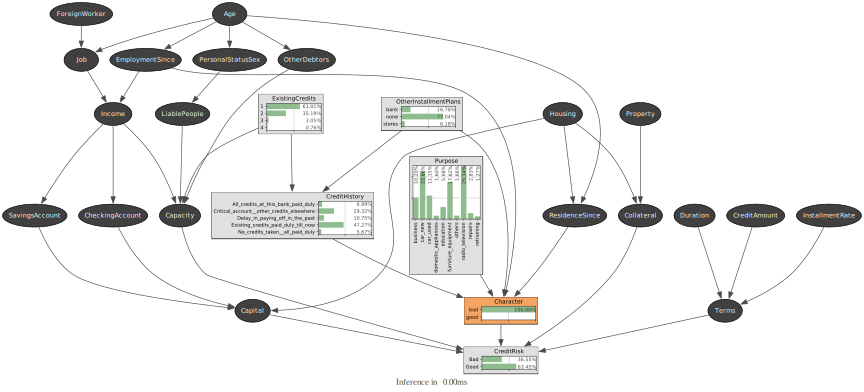

In [31]:
targets = {"CreditRisk", "Character", "CreditHistory", "ExistingCredits", "Purpose", "OtherInstallmentPlans"}

gnb.showInference(bn,evs={"Character": "good"}, targets=targets, size="12")
gnb.showInference(bn,evs={"Character": "bad"}, targets=targets, size="12")

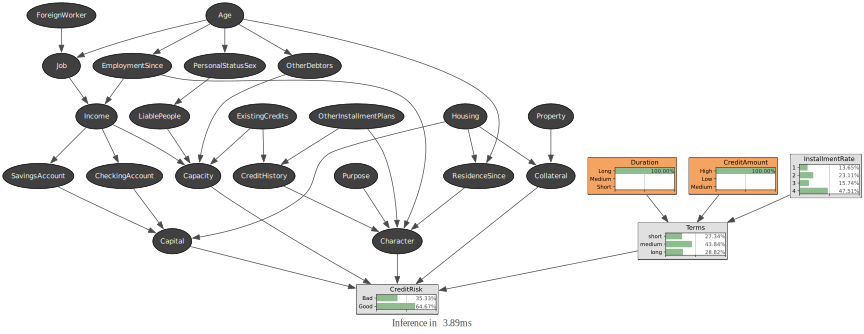

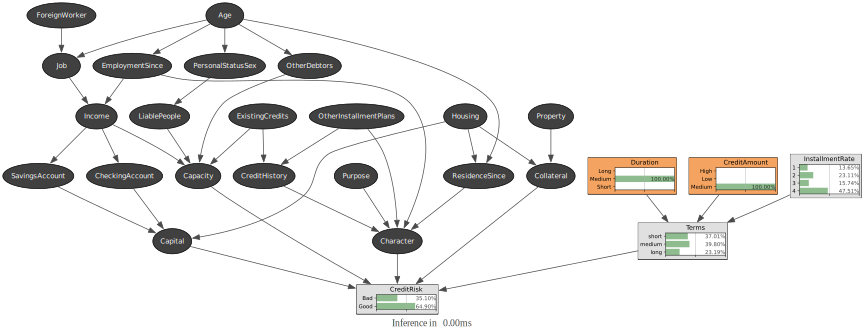

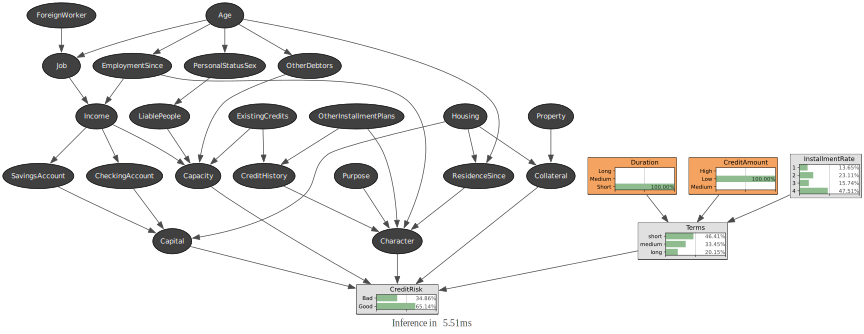

In [32]:
targets = {"CreditRisk", "Terms", "Duration", "CreditAmount", "InstallmentRate"}

gnb.showInference(bn,evs={"Duration": "Long", "CreditAmount": "High"}, targets=targets, size="12")
gnb.showInference(bn,evs={"Duration": "Medium", "CreditAmount": "Medium"}, targets=targets, size="12")
gnb.showInference(bn,evs={"Duration": "Short", "CreditAmount": "Low"}, targets=targets, size="12")

In [33]:
# Save the bn
bn.saveBIF('BNs/GermanCreditManual_filled.bif')

# Creating Influence diagram


Ensuring that 5 C's are used in deciding whether to approve or deny loan

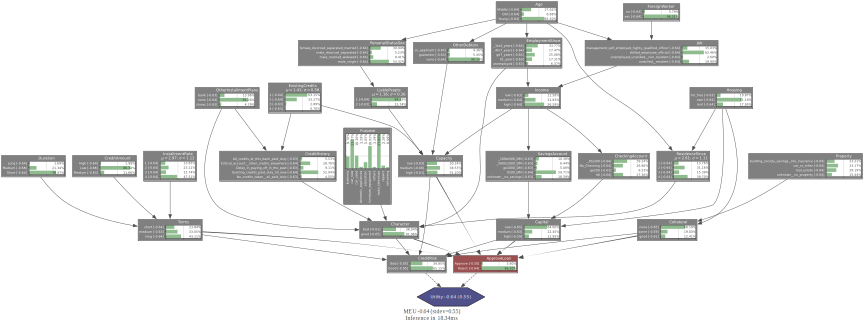

In [34]:
# Load the influence diagram
influence_diagram = gum.loadID('IDs/credit_decision_influence_diagram.xml')

# Add the parents of credit risk to the action node

parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    influence_diagram.addArc(parent_name, decision_name)

gnb.showInference(influence_diagram, size="12")

# Inference using the influence diagram


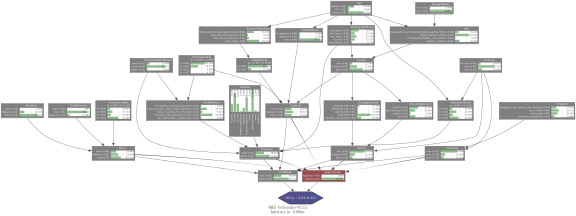

In [35]:
# Diagnostic Inference
gnb.showInference(influence_diagram)


Suppose we want to determine, given short and long-term credit applicatons which decision would be optimal, and would we prefer taking either option over the other.

In [36]:
ie=gum.ShaferShenoyLIMIDInference(influence_diagram)
ie.makeInference()
display(ie.optimalDecision("ApproveLoan"))
display(ie.posteriorUtility("ApproveLoan"))


(pyagrum.Tensor@000002064FE16810) 
                                  ||  ApproveLoan      |
Terms |Capita|Collat|Capaci|Charac||Approve  |Reject   |
------|------|------|------|------||---------|---------|
short |low   |none  |low   |bad   || 0.0000  | 1.0000  |
medium|low   |none  |low   |bad   || 0.0000  | 1.0000  |
long  |low   |none  |low   |bad   || 0.0000  | 1.0000  |
short |medium|none  |low   |bad   || 0.0000  | 1.0000  |
medium|medium|none  |low   |bad   || 0.0000  | 1.0000  |
long  |medium|none  |low   |bad   || 0.0000  | 1.0000  |
[...150 more line(s) ...]
short |medium|good  |high  |good  || 0.0000  | 1.0000  |
medium|medium|good  |high  |good  || 0.0000  | 1.0000  |
long  |medium|good  |high  |good  || 0.0000  | 1.0000  |
short |high  |good  |high  |good  || 0.0000  | 1.0000  |
medium|high  |good  |high  |good  || 0.0000  | 1.0000  |
long  |high  |good  |high  |good  || 0.0000  | 1.0000  |

(pyagrum.Tensor@000002064B7064C8) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 -0.4987 | -0.6417 |

(pyagrum.Tensor@000002064B707D88) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 -0.7143 | -0.6355 |

(pyagrum.Tensor@000002064FE18AB0) 
                                  ||  ApproveLoan      |
Terms |Capita|Collat|Capaci|Charac||Approve  |Reject   |
------|------|------|------|------||---------|---------|
short |low   |none  |low   |bad   || 0.0000  | 1.0000  |
medium|low   |none  |low   |bad   || 1.0000  | 0.0000  |
long  |low   |none  |low   |bad   || 1.0000  | 0.0000  |
short |medium|none  |low   |bad   || 0.0000  | 1.0000  |
medium|medium|none  |low   |bad   || 1.0000  | 0.0000  |
long  |medium|none  |low   |bad   || 1.0000  | 0.0000  |
[...150 more line(s) ...]
short |medium|good  |high  |good  || 0.0000  | 1.0000  |
medium|medium|good  |high  |good  || 1.0000  | 0.0000  |
long  |medium|good  |high  |good  || 1.0000  | 0.0000  |
short |high  |good  |high  |good  || 0.0000  | 1.0000  |
medium|high  |good  |high  |good  || 1.0000  | 0.0000  |
long  |high  |good  |high  |good  || 1.0000  | 0.0000  |

(pyagrum.Tensor@000002064B704F08) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 -0.3876 | -0.6447 |

(pyagrum.Tensor@000002064FE18F50) 
                                  ||  ApproveLoan      |
Terms |Capita|Collat|Capaci|Charac||Approve  |Reject   |
------|------|------|------|------||---------|---------|
short |low   |none  |low   |bad   || 1.0000  | 0.0000  |
medium|low   |none  |low   |bad   || 0.0000  | 1.0000  |
long  |low   |none  |low   |bad   || 1.0000  | 0.0000  |
short |medium|none  |low   |bad   || 1.0000  | 0.0000  |
medium|medium|none  |low   |bad   || 0.0000  | 1.0000  |
long  |medium|none  |low   |bad   || 1.0000  | 0.0000  |
[...150 more line(s) ...]
short |medium|good  |high  |good  || 1.0000  | 0.0000  |
medium|medium|good  |high  |good  || 0.0000  | 1.0000  |
long  |medium|good  |high  |good  || 1.0000  | 0.0000  |
short |high  |good  |high  |good  || 1.0000  | 0.0000  |
medium|high  |good  |high  |good  || 0.0000  | 1.0000  |
long  |high  |good  |high  |good  || 1.0000  | 0.0000  |

(pyagrum.Tensor@000002064B705FE8) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 -0.6250 | -0.6430 |

(pyagrum.Tensor@000002064FE18F50) 
                                  ||  ApproveLoan      |
Terms |Capita|Collat|Capaci|Charac||Approve  |Reject   |
------|------|------|------|------||---------|---------|
short |low   |none  |low   |bad   || 1.0000  | 0.0000  |
medium|low   |none  |low   |bad   || 1.0000  | 0.0000  |
long  |low   |none  |low   |bad   || 0.0000  | 1.0000  |
short |medium|none  |low   |bad   || 1.0000  | 0.0000  |
medium|medium|none  |low   |bad   || 1.0000  | 0.0000  |
long  |medium|none  |low   |bad   || 0.0000  | 1.0000  |
[...150 more line(s) ...]
short |medium|good  |high  |good  || 1.0000  | 0.0000  |
medium|medium|good  |high  |good  || 1.0000  | 0.0000  |
long  |medium|good  |high  |good  || 0.0000  | 1.0000  |
short |high  |good  |high  |good  || 1.0000  | 0.0000  |
medium|high  |good  |high  |good  || 1.0000  | 0.0000  |
long  |high  |good  |high  |good  || 0.0000  | 1.0000  |

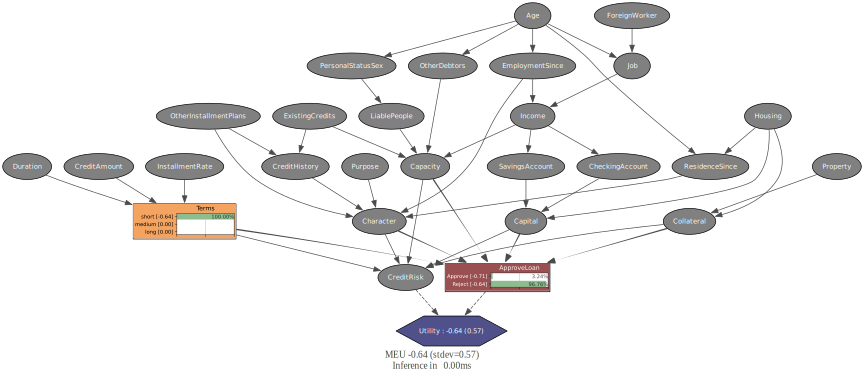

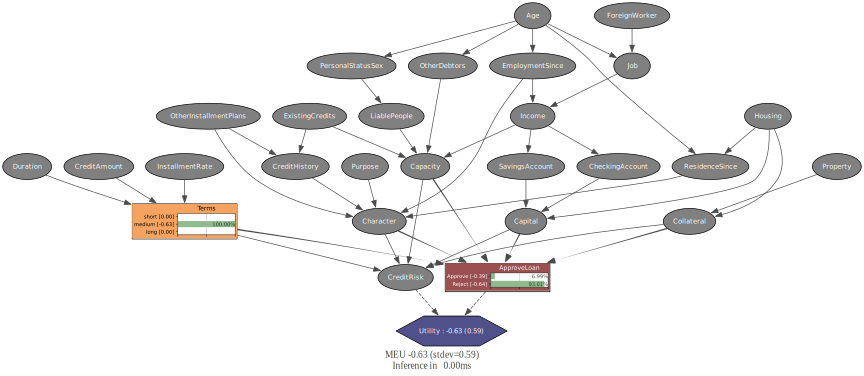

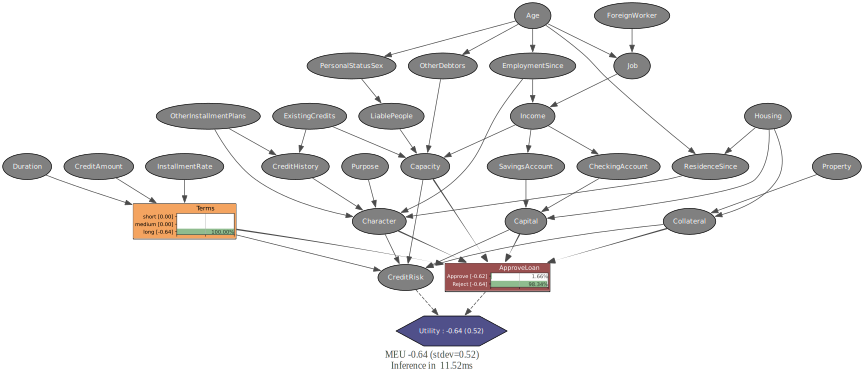

In [37]:

ie.setEvidence({"Terms": "short"})
ie.makeInference()
display(ie.posteriorUtility("ApproveLoan"))
display(ie.optimalDecision("ApproveLoan"))

ie.setEvidence({"Terms": "medium"})
ie.makeInference()
display(ie.posteriorUtility("ApproveLoan"))
display(ie.optimalDecision("ApproveLoan"))

ie.setEvidence({"Terms": "long"})
ie.makeInference()
display(ie.posteriorUtility("ApproveLoan"))
display(ie.optimalDecision("ApproveLoan"))

gnb.showInference(influence_diagram,evs={"Terms": "short"}, targets=["ApproveLoan", "Terms"], size="12")
gnb.showInference(influence_diagram,evs={"Terms": "medium"}, targets=["ApproveLoan", "Terms"], size="12")
gnb.showInference(influence_diagram,evs={"Terms": "long"}, targets=["ApproveLoan", "Terms"], size="12")


Suppose a scenario where we have an individual with capacity to pay their credit, but they don't necessarily have the collateral to put forward for their loan. 

In [38]:
ie.setEvidence({"Capacity": "high", "Collateral": "none"})
ie.makeInference()
display(ie.posteriorUtility("ApproveLoan"))

ie.setEvidence({"Capacity": "medium", "Collateral": "none"})
ie.makeInference()
display(ie.posteriorUtility("ApproveLoan"))


(pyagrum.Tensor@000002064B705148) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 -0.4366 | -0.6614 |

(pyagrum.Tensor@000002064B706FA8) 
  ApproveLoan      |
Approve  |Reject   |
---------|---------|
 0.0000  | -0.6899 |

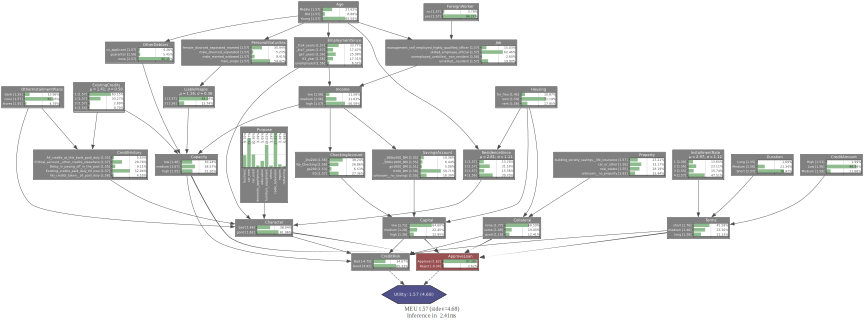

In [39]:
# After modifying the utility function
# Load the influence diagram
updated_id = gum.loadID('IDs/updated_utility.xml')

# Add the parents of credit risk to the action node
parents = bn.parents("CreditRisk")
decision_name = "ApproveLoan"

for parent in parents:
    parent_name = bn.variable(parent).name()
    updated_id.addArc(parent_name, decision_name)

gnb.showInference(updated_id, size="12")